In [1]:
import numpy as np
import pandas as pd
import datetime, requests

In [2]:
def geckoHistorical(ticker, vs_currency='usd', days='max'):
    url = f"https://api.coingecko.com/api/v3/coins/{ticker}/market_chart"
    params = {"vs_currency":{vs_currency}, "days":days}
    r = requests.get(url, params).json()
    prices = pd.DataFrame(r['prices'])
    market_caps = pd.DataFrame(r['market_caps'])
    total_volumes = pd.DataFrame(r['total_volumes'])
    df = pd.concat([prices, market_caps[1], total_volumes[1]], axis=1)
    df[0] = pd.to_datetime(df[0], unit='ms')
    df.columns = ['date','price','market_caps','total_volumes']
    df.set_index('date', inplace=True)

    return df

tickers = ['bitcoin','ethereum']

series = []
for ticker in tickers:
    series.append(geckoHistorical(ticker)['price'].resample('D').last())
    
df = pd.concat(series, axis=1)
df.columns = tickers

In [3]:
retornos = np.log((df/df.shift(1)).dropna())
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 365
    d['volatilidad'] = retornos[ticker].std() * (365**0.5)
    d['sharpe'] = d['retorno'] / d['volatilidad']
    datosTickers.append(d)
    

datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
bitcoin,0.773268,0.755054,1.024123
ethereum,1.178206,1.194604,0.986273


In [4]:
q = 5000
carteras = [] 

for i in range(q):
    print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}
    r['retorno'] = np.sum( (retornos.mean() * pond * 365))
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*365, pond)))
    r['sharpe'] = r['retorno'] / r['volatilidad'] 
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port

In [5]:
optimo

retorno                0.917646
volatilidad            0.804332
sharpe                  1.14088
pesos          [0.6435, 0.3565]
Name: 4603, dtype: object

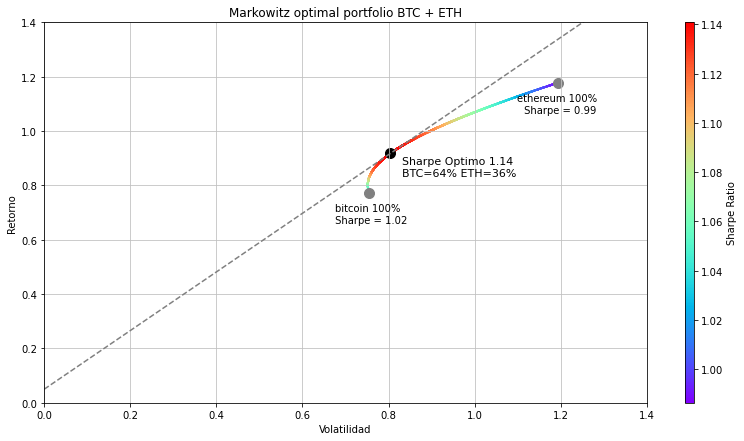

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13.5,7))

plt.scatter(carteras.volatilidad, carteras.retorno, c=carteras.sharpe, s=1, cmap='rainbow')

plt.colorbar(label='Sharpe Ratio', aspect=40)
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')

plt.scatter(optimo.volatilidad, optimo.retorno,c='k', alpha=1, s=100) 

opt_txt =  f'Sharpe Optimo {optimo.sharpe:.2f} \nBTC={datosTickers.loc["bitcoin","ponderacion_optima"]:.0%}'
opt_txt += f' ETH={datosTickers.loc["ethereum","ponderacion_optima"]:.0%}'

plt.text(optimo.volatilidad+0.16, optimo.retorno-0.05, opt_txt, fontsize=11, c='k', ha='center', va='center') 

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad'] 
    ret = datosTickers.loc[ticker,'retorno'] 
    plt.scatter(vol, ret,  alpha=1, c='gray', s=100) 
    ticker_txt = f"{ticker} 100% \n Sharpe = {datosTickers.loc[ticker,'sharpe']:.2f}"
    plt.text(vol, ret-0.08, ticker_txt, c='k', ha='center', va='center') 
    
    
free_risk = 0.05
m = (optimo.retorno - free_risk) / (optimo.volatilidad)
x2 = 1.5
y2 = x2*m + free_risk
ax.plot(np.linspace(0,x2), np.linspace(free_risk, y2), color='gray', ls='--')

ax.set_xlim(0.0,1.4)
ax.set_ylim(0.0,1.4)
ax.grid(color='silver')
ax.set_title('Markowitz optimal portfolio BTC + ETH')
plt.show()

In [21]:
tickers = ['bitcoin','cardano','solana', 'ethereum']

series = []
for ticker in tickers:
    series.append(geckoHistorical(ticker)['price'].resample('D').last())
    
df = pd.concat(series, axis=1)
df.columns = tickers

retornos = np.log((df/df.shift(1)).dropna())
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 365
    d['volatilidad'] = retornos[ticker].std() * (365**0.5)
    d['sharpe'] = d['retorno'] / d['volatilidad']
    datosTickers.append(d)
    

datosTickers = pd.DataFrame(datosTickers).set_index('ticker')

q = 5000
carteras = [] 

for i in range(q):
    print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}
    r['retorno'] = np.sum( (retornos.mean() * pond * 365))
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*365, pond)))
    r['sharpe'] = r['retorno'] / r['volatilidad'] 
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
bitcoin,1.016345,0.704331,1.442994,0.1131
cardano,1.936660,1.140960,1.697395,0.3501
solana,2.609014,1.615686,1.614802,0.2564
ethereum,1.630894,0.942117,1.731096,0.2805


In [22]:
optimo

retorno                                1.919258
volatilidad                            0.943201
sharpe                                 2.034835
pesos          [0.1131, 0.3501, 0.2564, 0.2805]
Name: 4740, dtype: object

KeyError: 'polkadot'

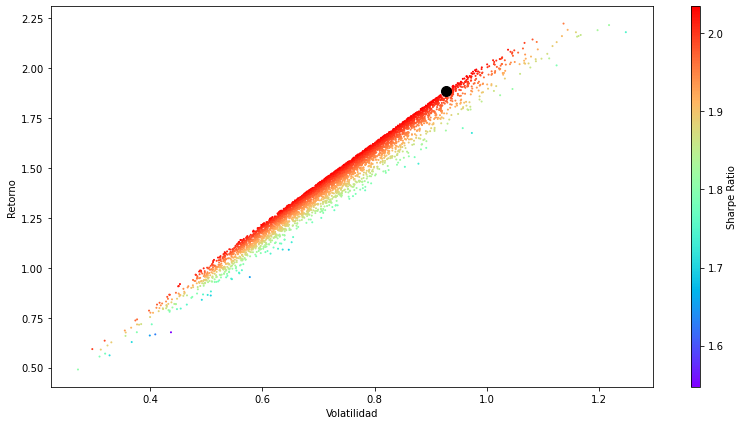

In [19]:
fig, ax = plt.subplots(figsize=(13.5,7))

plt.scatter(carteras.volatilidad, carteras.retorno, c=carteras.sharpe, s=1, cmap='rainbow')

plt.colorbar(label='Sharpe Ratio', aspect=40)
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')

plt.scatter(optimo.volatilidad, optimo.retorno,c='k', alpha=1, s=100) 

opt_txt =  f'Sharpe Optimo {optimo.sharpe:.2f} \nBTC={datosTickers.loc["bitcoin","ponderacion_optima"]:.0%}'
opt_txt += f' ADA={datosTickers.loc["cardano","ponderacion_optima"]:.0%}'
opt_txt += f' DOT={datosTickers.loc["polkadot","ponderacion_optima"]:.0%}'

plt.text(optimo.volatilidad+0.16, optimo.retorno-0.05, opt_txt, fontsize=11, c='k', ha='center', va='center') 

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad'] 
    ret = datosTickers.loc[ticker,'retorno'] 
    plt.scatter(vol, ret,  alpha=1, c='gray', s=100) 
    ticker_txt = f"{ticker}"
    plt.text(vol, ret-0.08, ticker_txt, c='k', ha='center', va='center') 
    
    
free_risk = 0.05
m = (optimo.retorno - free_risk) / (optimo.volatilidad)
x2 = 1.5
y2 = x2*m + free_risk
ax.plot(np.linspace(0,x2), np.linspace(free_risk, y2), color='gray', ls='--')

ax.set_xlim(0.0,1.6)
ax.set_ylim(0.0,1.75)
ax.grid(color='silver')
ax.set_title('Markowitz optimal portfolio BTC + ADA + DOT')
plt.show()

In [10]:
tickers = ['bitcoin','ethereum','cardano','polkadot']

series = []
for ticker in tickers:
    series.append(geckoHistorical(ticker)['price'].resample('D').last())
    
df = pd.concat(series, axis=1)
df.columns = tickers

retornos = np.log((df/df.shift(1)).dropna())

print('\n\nMatriz de Correlacion entre BTC-ETH-ADA-DOT')
retornos.corr().style.background_gradient(cmap='Blues')



Matriz de Correlacion entre BTC-ETH-ADA-DOT


,bitcoin,ethereum,cardano,polkadot
bitcoin,1.000000,0.772393,0.604827,0.626748
ethereum,0.772393,1.000000,0.669862,0.692184
cardano,0.604827,0.669862,1.000000,0.601788
polkadot,0.626748,0.692184,0.601788,1.000000
